In [2]:
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import astropy.io
import astropy.table
import scipy
import pandas as pd
import galstreams
import gcutils
import gala
import gala.coordinates as gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [253]:
def mean_of_skycoords(coo):
    """
    Compute vector mean of SkyCoord inputs. Returns SkyCoord object
    """
    sum_coo = ac.SkyCoord(x=np.sum(coo.cartesian.x),
                          y=np.sum(coo.cartesian.y),
                          z=np.sum(coo.cartesian.z),
                          frame=ac.ICRS, representation_type='cartesian')
    #Surely there's a more elegant way of doing this. No patience right now. This is pretty clearly right.
    sum_coo = ac.SkyCoord(ra=sum_coo.spherical.lon, dec=sum_coo.spherical.lat)
    #sum_coo = sum_coo.unitspherical ?
    
    return sum_coo

def get_track_from_points(sc, N=200, deg=3):
    """ Estimate the mean track from a set of stream stars or points 

        Parameters
        ----------
        sc : `astropy.coordinates.SkyCoord` instance 

    """
    
    
    #find mean
    center=mean_of_skycoords(sc)
    #to get the extremes I should wrap the angles at the center and then get min/max. this is general
    aux = ac.SkyCoord(ra=sc[[5,-5]].ra.value,dec=sc[[5,-5]].dec.value,unit=u.deg)
    
    
    pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    fr = gc.GreatCircleICRSFrame(pole=pole,ra0=center.ra)
    scp = sc.transform_to(fr)

    
    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.deg, deg=deg))

    phi1_end_points = phi1s[[0,-1]]
    
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit(mean_phi1.value)*scp.phi2.unit

    track_mid_point = ac.SkyCoord(phi1=mean_phi1, phi2=phi2_mid, frame=fr)
    
    #Initial track object
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2_fit(phi1s.value)*u.deg, frame=fr)

    #Recompute the track using two points in the track, close to the center, at both sides (this ensures mid point is close to phi2=0)
    two_points_near_mid = ac.SkyCoord(phi1=[-0.5,0.5]*u.deg, phi2=phi2_fit([-0.5,0.5])*u.deg, frame=fr)
    two_points_near_mid = ac.SkyCoord(phi1=[mean_phi1-0.5*u.deg,mean_phi1+0.5*u.deg]*u.deg, phi2=phi2_fit([mean_phi1.deg-0.5,mean_phi1.deg+0.5])*u.deg, frame=fr)
    aux=ac.SkyCoord(ra=two_points_near_mid.transform_to(ac.ICRS).ra.value, dec=two_points_near_mid.transform_to(ac.ICRS).dec.value, unit=u.deg)
    #aux=two_points_near_mid.icrs
    new_pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    
    #New stream's frame -------------------------------------------------------------------
    new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra)
    scp = sc.transform_to(new_fr)

    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi1_end_points = phi1s[[0,-1]]
    
    #Set up polynomial fit with explicit frame so it can take a SkyCoord object in any frame and do it's magic
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.value, deg=deg))
    phi2_track = phi2_fit(phi1s.deg)*scp.phi2.unit
    phi2_end = phi2_track[[0,-1]]
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit([mean_phi1.value,])*scp.phi2.unit
    
    #In general phi1=0 in the initiall guess frame is not necesarily contained between the end points
    
    mid_dict = dict(frame=new_fr, phi1=mean_phi1, phi2=phi2_mid)
    end_dict = dict(frame=new_fr, phi1= phi1_end_points, phi2=phi2_end)
    track_dict = dict(frame=new_fr, phi1 = phi1s, phi2 = phi2_track)
    fits = dict(phi2=phi2_fit)
    
    for att in ["distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        if att=="distance" or 's' in scp.data.differentials:  #i.e. if obj contains velocity data
            att_fit = np.poly1d(np.polyfit(scp.phi1.deg, getattr(scp,att).value, deg=deg))  #polynomial fit obj
            track_dict[att] = att_fit(phi1s.deg)*getattr(scp,att).unit   #eval track-fit to get track for current attr
            mid_dict[att] = att_fit([mean_phi1.value,])*getattr(scp,att).unit
            end_dict[att] = att_fit(phi1_end_points.deg)*getattr(scp,att).unit
        else:
            fits[att] = None
            track_dict[att] = None
            mid_dict[att] = None
            end_dict[att] = None

    newtrack = ac.SkyCoord(**track_dict)       
    track_end_points = ac.SkyCoord(**end_dict)
    track_mid_point = ac.SkyCoord(**mid_dict)
 
    #Re-recompute stream frame to make sure mid_point ends up at phi1=0
    new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.transform_to(ac.ICRS).ra[0])


    #Store width track
    track_width = np.std(scp.phi2)*np.ones(newtrack.phi2.size)  #TODO: turn this into rolling std
    
    #Re-store so that new_pole is iterable. Saves me trouble later
    new_pole = ac.SkyCoord(ra=np.array([new_pole.ra.deg,]), dec=np.array([new_pole.dec.deg,]), unit=u.deg)

    return (newtrack.transform_to(ac.ICRS), track_width, track_end_points.transform_to(ac.ICRS), track_mid_point.transform_to(ac.ICRS), 
            new_pole.transform_to(ac.ICRS), new_fr, fits)


In [90]:
def save_track_ecsv(outfilen,track):
    
    #Save track
    names = track.get_representation_component_names()
    names.update(track.get_representation_component_names('s'))
    t = astropy.table.QTable( {k: getattr(track, k) for k in names})
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   


def save_summary_ecsv(outfilen, track_end_points, track_mid_point, mid_pole, StreamName="0", StreamShortName="0"):
    
    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    #ofilesn = f"{ofileroot}.summary.ecsv"
    names = track_end_points.get_representation_component_names()
    names.update(track_end_points.get_representation_component_names('s'))
    
    
    tr_summary = dict(StreamName=np.array([StreamName,]), StreamShortName=np.array([StreamShortName,]))
    lnames = [ "end_o."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[:1], k) for k,l in zip(names,lnames)})
    lnames = [ "end_f."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[1:], k) for k,l in zip(names,lnames)})
    lnames = [ "mid."+k for k in names]
    tr_summary.update({l: getattr(track_mid_point[:1], k) for k,l in zip(names,lnames)})
    rnames = mid_pole.get_representation_component_names()
    lnames = [ "pole."+k for k in rnames]
    tr_summary.update({l: getattr(mid_pole[:1], k) for k,l in zip(rnames,lnames)})
    #print track summary
    t = astropy.table.QTable(tr_summary)
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   
    

In [59]:
def stream_plot(stream_sc, track, track_end_points, track_mid_point, stream_fr, saveplot=False, clf=False, StreamName=None, plotfilen='salida.png', plot_obs=True):
    
    pkwds=dict(marker='.',ls='', alpha=0.5)
    tkwds=dict(marker='',ls='-', lw=2, color='orange')
    mkw=dict(marker='D',ls='', color='k')
    ekw=dict(marker='o',ls='', color='k')

    nx, ny = 2, 5
    fig=plt.figure(1,figsize=(10,10))
    axs = fig.subplots(ny,nx, sharex="col")

    if plot_obs: stream_plot_card(stream_sc, stream_fr, axs, plotkwds=pkwds )
    stream_plot_card(track, stream_fr, axs, plotkwds=tkwds)
    stream_plot_card(track_end_points, stream_fr, axs, plotkwds=ekw)
    stream_plot_card(track_mid_point, stream_fr, axs, plotkwds=mkw, show_labels=True)
    
    if StreamName: fig.suptitle("Stream: "+StreamName) 

    fig.tight_layout(rect=[0,0,1,0.97])

    if saveplot: fig.savefig(plotfilen)
    if clf:     fig.clf()


In [11]:
def stream_plot_card(sc, stream_fr, axs, plotkwds={}, show_labels=False, show_grid=False):

    

    labels1=dict(phi2="$\phi_2$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_phi1_cosphi2="$\mu\phi1$ (arcsec/yr)", pm_phi2="$\mu\phi2$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    labels2=dict(ra="$\\alpha$ ($\degree$)",dec="$\delta$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_ra_cosdec="$\mu\\alpha$ (arcsec/yr)", pm_dec="$\mu\delta$ (arcsec/yr)",
                 radial_velocity="$v_r$ (km/s)")
    
    #Plots in stream frame coords    
    r,c=0,0    
    for att in ["phi2","distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        try:
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.transform_to(stream_fr).phi1, getattr(sc.transform_to(stream_fr),att), **plotkwds)
                if (np.abs(getattr(sc.transform_to(stream_fr),att).value)>1e-10).sum()==0 :
                    axs[r,0].set_ylim(-10,10)
        except TypeError or ValueError: print("No kinematic data...")        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\phi_1$ ($\degree$)")
            axs[r,c].set_ylabel(labels1[att])
        r=r+1

    #Plots in equatorial coords
    r,c=0,1  
    for att in ["dec","distance", "pm_ra_cosdec", "pm_dec",  "radial_velocity"]:
        try:
            #if hasattr(sc.icrs, att): 
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.icrs.ra.wrap_at, getattr(sc.icrs,att), **plotkwds)
                if (np.abs(getattr(sc.icrs,att).value)>1e-10).sum()==0 :
                    #axs[r,0].set_ylim(-10,10)
                    axs[r,1].set_ylim(-10,10)       
        except TypeError or ValueError: print("No kinematic data...")                        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\\alpha$ ($\degree$)")
            axs[r,c].set_ylabel(labels2[att])
            
        r=r+1
    
    #return f, axs

In [263]:
def generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=3, ShortName=None, clf=True, plot_obs=True, verbose=True):
    '''
        Generate track from points, plot it and store track and track summary in ecsv files
        
        Parameters:
        
        obs: SkyCoord Object. Must contain velocity data
        
        Name: String - Stream's name
        
        Ref: String - Main Reference for stream track
        
        Optional:
        
        mid_point: SkyCoord - not implemented yet. When it is it will override the auto-computed mid_point
    '''
    
    if ShortName is None:  ShortName=Name[:3]

    track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits = get_track_from_points(obs.icrs, deg=deg)

    #Print track out
    ofileroot = f"track.st.{Name}.{Ref.lower()}"
    if verbose: print(f"{Name} -> {ofileroot}.ecsv")
    save_track_ecsv(f"{ofileroot}.ecsv",track)

    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    ofilesn = f"{ofileroot}.summary.ecsv"    
    save_summary_ecsv(ofilesn, track_end_points, track_mid_point, mid_pole, StreamName=Name, StreamShortName=ShortName )

    #While we're at it. Make plot and save
    stream_plot(obs, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png",  clf=clf, StreamName=Name, plot_obs=plot_obs)
    
    #Save poly-footprint
    #here...



Tracks init by end points
==========================

In [143]:
tpair = astropy.io.ascii.read("../support_data/lib_by_pair.dat",header_start=4)
#tpair.replace_column('Ro', tpair["Ro"].astype(float))
tpair

Name,ShortName,lono,lato,lonf,latf,frame,Ro,Rf,Width,Reference
str11,str5,float64,float64,float64,float64,str3,float64,float64,float64,str26
Phoenix,Phe,20.0,-57.0,27.0,-45.0,equ,17.5,17.5,0.18,Balbinot2016
Acheron,Ach,230.0,-2.0,259.0,21.0,equ,3.5,3.8,0.9,Grillmair2009
Cocytos,Coc,186.0,-3.0,259.0,20.0,equ,11.0,11.0,0.7,Grillmair2009
Lethe,Let,171.0,18.0,258.0,20.0,equ,13.0,13.0,0.4,Grillmair2009
Styx,Sty,194.0,20.0,259.0,21.0,equ,45.0,45.0,3.3,Grillmair2009
ACS,ACS,126.4,-0.7,133.9,64.2,equ,8.9,8.9,5.0,Grillmair2006
Pal15,Pal15,254.8,-0.12,255.3,-1.47,equ,38.4,38.4,0.0,Myeong2017
Eridanus,Eri,65.98,-21.42,66.4,-20.96,equ,95.0,95.0,0.0,Myeong2017
TucanaIII,Tuc3,-6.3,-59.7,3.2,-59.4,equ,23.0,27.0,0.18,"Shipp2018,DrlicaWagner2015"


In [264]:
gcstep=0.1
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")

for i in range(tpair["lono"].size)[:]:

    Name, ShortName, Reference = tpair["Name"][i], tpair["ShortName"][i], tpair["Reference"][i] 
    print(i,Name)

    #End points
    track_end_point_o = ac.SkyCoord(tpair["lono"][i]*u.deg ,tpair["lato"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])
    track_end_point_f = ac.SkyCoord(tpair["lonf"][i]*u.deg ,tpair["latf"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])

    track_end_points = ac.SkyCoord(np.array([tpair["lono"][i],tpair["lonf"][i]])*u.deg,
                                   np.array([tpair["lato"][i],tpair["latf"][i]])*u.deg,
                                   distance=np.array([tpair["Ro"][i],tpair["Rf"][i]])*u.kpc,
                                   frame=coo_frame[tpair["frame"][i]],
                                   pm_ra_cosdec=np.zeros(2)*u.arcsec/u.yr, 
                                   pm_dec=np.zeros(2)*u.arcsec/u.yr)

    
    #Mid point. This track is, by definitiion a great circle. In this case, it is valid that the mean will be in the same plane and thus a valid mid-point
    track_mid_point = mean_of_skycoords(track_end_points)   
    
    mid_pole = gc.greatcircle.pole_from_endpoints(track_end_point_o, track_end_point_f)
    stream_fr = gc.GreatCircleICRSFrame(pole=mid_pole, ra0=track_mid_point.ra)
    
    #Generate sky track
    phis_o=np.linspace( (track_end_points.transform_to(stream_fr).phi1.value).min(),  (track_end_points.transform_to(stream_fr).phi1.value).max(), 200)
    phi1s = phis_o*track_end_points.ra.unit
    phi2 = np.zeros(phi1s.size)*phi1s.unit
    
    #Distance track - If a detailed track is lacking and only Ro,Rf are reported, nothing better to do than linear interpolation
    Fd = scipy.interpolate.interp1d([phis_o[0],phis_o[-1]],[tpair["Ro"][i],tpair["Rf"][i]],kind='linear',bounds_error=False)
    distance = Fd(phi1s.value)*u.kpc    #Ro,Rf are passed in kpc

    
    #In this category, for now it's assumed no proper motion data is available. If it is, move to Individual stream category
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2, 
                        distance=distance,
                        frame=stream_fr, 
                        pm_phi1_cosphi2=np.zeros(phi2.size)*u.arcsec/u.yr, 
                        pm_phi2=np.zeros(phi2.size)*u.arcsec/u.yr)

    #Objects are stored in icrs by default
    track_mid_point = ac.SkyCoord(ra=track_mid_point.ra*np.ones(1), dec=track_mid_point.dec*np.ones(1), 
                                  distance=Fd(0.)*u.kpc, frame="icrs", 
                                  pm_ra_cosdec=np.zeros(1)*u.arcsec/u.yr, pm_dec=np.zeros(1)*u.arcsec/u.yr )    


    mid_pole = ac.SkyCoord(ra=mid_pole.ra*np.ones(1), dec=mid_pole.dec*np.ones(1), distance=np.zeros(1), frame="icrs", 
                           pm_ra_cosdec=np.zeros(1)*u.arcsec/u.yr, pm_dec=np.zeros(1)*u.arcsec/u.yr )


    ofileroot = f"track.ep.{Name}.{Reference.lower()}"

    #Save plots
    stream_plot(track, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png", clf=True, StreamName=Name, plot_obs=False)

    #Print track out
    ofileroot = f"track.ep.{Name}.{Reference.lower()}"
    print(f"{Name} -> {ofileroot}.ecsv")
    save_track_ecsv(f"{ofileroot}.ecsv",track = track.icrs)

    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    ofilesn = f"{ofileroot}.summary.ecsv"    
    save_summary_ecsv(ofilesn, track_end_points.icrs, track_mid_point.icrs, mid_pole.icrs, StreamName=Name, StreamShortName=ShortName )
    



0 Phoenix
Phoenix -> track.ep.Phoenix.balbinot2016.ecsv
1 Acheron
Acheron -> track.ep.Acheron.grillmair2009.ecsv
2 Cocytos
Cocytos -> track.ep.Cocytos.grillmair2009.ecsv
3 Lethe
Lethe -> track.ep.Lethe.grillmair2009.ecsv
4 Styx
Styx -> track.ep.Styx.grillmair2009.ecsv
5 ACS
ACS -> track.ep.ACS.grillmair2006.ecsv
6 Pal15
Pal15 -> track.ep.Pal15.myeong2017.ecsv
7 Eridanus
Eridanus -> track.ep.Eridanus.myeong2017.ecsv
8 TucanaIII
TucanaIII -> track.ep.TucanaIII.shipp2018,drlicawagner2015.ecsv
9 Indus
Indus -> track.ep.Indus.shipp2018.ecsv
10 Jhelum
Jhelum -> track.ep.Jhelum.shipp2018.ecsv
11 Ravi
Ravi -> track.ep.Ravi.shipp2018.ecsv
12 Chenab
Chenab -> track.ep.Chenab.shipp2018.ecsv
13 Elqui
Elqui -> track.ep.Elqui.shipp2018.ecsv
14 Aliqa_Uma
Aliqa_Uma -> track.ep.Aliqa_Uma.shipp2018.ecsv
15 Turbio
Turbio -> track.ep.Turbio.shipp2018.ecsv
16 Willka_Yaku
Willka_Yaku -> track.ep.Willka_Yaku.shipp2018.ecsv
17 Turranburra
Turranburra -> track.ep.Turranburra.shipp2018.ecsv
18 Wambelong
Wambelo

<Figure size 720x720 with 0 Axes>

In [102]:
mwsts=galstreams.MWStreams(verbose=False)

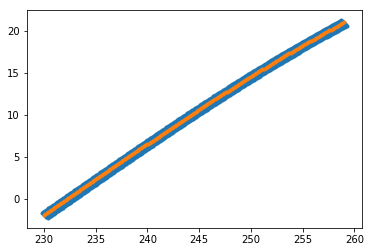

In [110]:
#Read-in validation
ofilen="track.ep.Acheron.grillmair2009.ecsv"
t = astropy.table.QTable.read(ofilen)
sc = ac.SkyCoord(**t)

#rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Acheron"].ra,mwsts["Acheron"].dec,'.')
plt.plot(sc.ra.deg,sc.dec.deg,'.')

Tracks init by pole
====================

In [53]:
tpoles = astropy.io.ascii.read("../support_data/lib_by_pole.dat",header_start=2)
tpoles

Name,pole_lon,pole_lat,pole_frame,center_lon,center_lat,cent_frame,dlon_deg,dlat,Ro,Rf,Reference
str9,float64,float64,str3,float64,float64,str3,float64,float64,float64,float64,str13
PS1-A,300.856,20.732,equ,160.17,-62.27,gal,5.0,0.45,7.9,7.9,Bernard2016
PS1-B,65.603,32.567,equ,248.41,32.3,gal,10.0,0.45,14.5,14.5,Bernard2016
PS1-C,232.227,33.838,equ,75.12,-32.6,gal,8.0,0.333,17.4,17.4,Bernard2016
PS1-D,49.64,2.467,equ,231.06,32.83,gal,45.0,0.867,22.9,22.9,Bernard2016
PS1-E,42.526,23.987,equ,144.17,58.4,gal,25.0,0.617,12.6,12.6,Bernard2016
ATLAS,77.16,46.92,equ,25.0,-30.0,equ,12.0,0.25,20.0,20.0,Koposov2014
Ophiuchus,184.32,77.25,equ,4.53,31.69,gal,2.5,0.12,9.5,9.5,Bernard2014
Sangarius,178.0,-52.0,gal,149.01,7.847,equ,59.0,0.44,21.0,21.0,Grillmair2017
Scamander,196.0,-41.0,gal,153.52,12.46,equ,66.0,0.22,21.0,21.0,Grillmair2017


In [55]:
tp=tpoles
for i in range(tp["Name"].size)[:]:
    _ = ac.galactocentric_frame_defaults.set('v4.0') 
    
    #Store pole and center coords, each in its own frame. 
    if "GC" not in tp["pole_frame"][i] and "GC" not in tp["cent_frame"][i]:
        pole_sc = ac.SkyCoord( tp["pole_lon"][i], tp["pole_lat"][i], unit=u.deg, frame=coo_frame[tp["pole_frame"][i]] )
        cent_sc = ac.SkyCoord( tp["center_lon"][i], tp["center_lat"][i], unit=u.deg, frame=coo_frame[tp["cent_frame"][i]] )
                             
        #Generate track from pole. Starting here, do everything in galactic
        azs,lats=gcutils.get_gc_for_pole(pole_sc.galactic.l.deg,pole_sc.galactic.b.deg,degree=True,
                                         center=[cent_sc.galactic.l.deg,cent_sc.galactic.b.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                                                       
        distance = np.ones_like(azs)*tp["Ro"][i]                                                            
        coo = ac.SkyCoord( azs*u.deg, lats*u.deg, frame="galactic", distance = distance*u.kpc )
    else:
        if "GC" not in tp["cent_frame"][i]:
                cent_sc=ac.SkyCoord(tp["center_lon"][i]*u.deg, tp["center_lat"][i]*u.deg, frame=coo_frame[tp["cent_frame"][i]], 
                                    distance=tp["Ro"][i]*u.kpc)
                cent_in_GC=cent_sc.transform_to(ac.Galactocentric)                 
        azs,lats=gcutils.get_gc_for_pole( tp["pole_lon"][i],tp["pole_lat"][i],degree=True,
                                         center=[cent_in_GC.spherical.lon.deg,cent_in_GC.spherical.lat.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                          
        distance=tp["Ro"][i]*np.ones_like(azs)                                                                     
        galcen = ac.SkyCoord(lon=azs*u.deg, lat=lats*u.deg, distance=distance*u.kpc, frame=ac.Galactocentric,  representation_type='spherical' )
        
        #Do it this way, instead of just gc.transform_to("galactic"), because extra info in SkyCoord obj due to Galactocentric initialization 
        #gives a RepresentationError when printing ecsv table
        coo = ac.SkyCoord(l=galcen.galactic.l, b=galcen.galactic.b, distance=galcen.galactic.distance, frame='galactic')                     

        
    width = tp["dlat"][i]*np.ones(np.size(coo.l))*u.kpc 
    
    
    #Print track
    print(tp["Name"][i],np.size(azs))
    ofilen="track.po.{Name}.{Ref}.ecsv".format(Name=tp["Name"][i], Ref=tp["Reference"][i].lower() )
    print("{N} {Name} -> {ofn}".format(N=i, Name=tp["Name"][i], ofn=ofilen))
    #as magic ECSV
    t = astropy.table.QTable([coo, width], names=['sc', 'width'])
    #t = astropy.table.QTable([coo], names=['sc'])

    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=ofilen, overwrite=True)   
    #print("printed")

PS1-A 50
0 PS1-A -> track.po.PS1-A.bernard2016.ecsv
PS1-B 100
1 PS1-B -> track.po.PS1-B.bernard2016.ecsv
PS1-C 80
2 PS1-C -> track.po.PS1-C.bernard2016.ecsv
PS1-D 450
3 PS1-D -> track.po.PS1-D.bernard2016.ecsv
PS1-E 250
4 PS1-E -> track.po.PS1-E.bernard2016.ecsv
ATLAS 120
5 ATLAS -> track.po.ATLAS.koposov2014.ecsv
Ophiuchus 25
6 Ophiuchus -> track.po.Ophiuchus.bernard2014.ecsv
Sangarius 502
7 Sangarius -> track.po.Sangarius.grillmair2017.ecsv
Scamander 653
8 Scamander -> track.po.Scamander.grillmair2017.ecsv
Corvus 3600
9 Corvus -> track.po.Corvus.mateu2018.ecsv


Individually initialized tracks
===================================

Ibata 2020 streams
------------------

In [50]:
ibt=astropy.io.ascii.read("../support_data/tab01_toCecilia.cat")
ib=ac.SkyCoord(ra=ibt["ra_epoch2000"]*u.deg, dec=ibt["dec_epoch2000"]*u.deg, distance=ibt["dis"]*u.kpc, 
                pm_ra_cosdec=ibt["pmra"]*u.mas/u.yr, pm_dec=ibt["pmdec"]*u.mas/u.yr)#, radial_velocity=np.zeros(ibt["dis"].size)*u.km/u.s)
ib.stream=ibt["stream"]

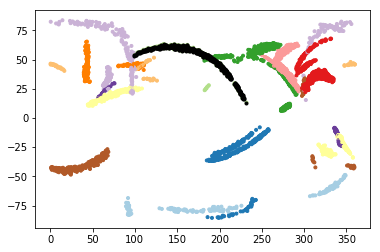

In [51]:
m=ib.stream==8
plt.scatter(ib.galactic.l,ib.galactic.b,c=ib.stream,marker='.',cmap=plt.cm.Paired)
plt.plot(ib.galactic.l[m],ib.galactic.b[m],'.k')

In [52]:
ib[m][-3]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (218.8535533, 58.7747837, 11.9)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-6.83, -1.416)>

In [53]:
#pole=gc.greatcircle.pole_from_endpoints(ib[m][0], ib[m][-3])

In [54]:
#np.unique(ib.stream)

In [262]:
i = 22 #8 22 #31
#It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
#TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.
mask = ib.ra>195*u.deg
ibs = ib[m & mask]
Ref = "ibata2020"
for i in np.unique(ib.stream)[:]:
    m = ib.stream==i
    ibs = ib[m]
    Name=f"{i}"

    generate_track_from_points_plot_and_store(ibs, Name, Ref, mid_point=None, ShortName=Name[:3], clf=True, plot_obs=True)


# Then, when reading it back in, it should be possible to do:
# t = at.QTable.read('filename.ecsv')
# sc = coord.SkyCoord(**t)




1 -> track.st.1.ibata2020.ecsv
2 -> track.st.2.ibata2020.ecsv
3 -> track.st.3.ibata2020.ecsv
4 -> track.st.4.ibata2020.ecsv
5 -> track.st.5.ibata2020.ecsv
6 -> track.st.6.ibata2020.ecsv
7 -> track.st.7.ibata2020.ecsv
8 -> track.st.8.ibata2020.ecsv
9 -> track.st.9.ibata2020.ecsv
10 -> track.st.10.ibata2020.ecsv
11 -> track.st.11.ibata2020.ecsv
12 -> track.st.12.ibata2020.ecsv
13 -> track.st.13.ibata2020.ecsv
14 -> track.st.14.ibata2020.ecsv
15 -> track.st.15.ibata2020.ecsv
16 -> track.st.16.ibata2020.ecsv
17 -> track.st.17.ibata2020.ecsv
18 -> track.st.18.ibata2020.ecsv
19 -> track.st.19.ibata2020.ecsv
20 -> track.st.20.ibata2020.ecsv
21 -> track.st.21.ibata2020.ecsv
22 -> track.st.22.ibata2020.ecsv
23 -> track.st.23.ibata2020.ecsv
24 -> track.st.24.ibata2020.ecsv
25 -> track.st.25.ibata2020.ecsv
26 -> track.st.26.ibata2020.ecsv
27 -> track.st.27.ibata2020.ecsv
28 -> track.st.28.ibata2020.ecsv
29 -> track.st.29.ibata2020.ecsv
30 -> track.st.30.ibata2020.ecsv
31 -> track.st.31.ibata2020.

<Figure size 720x720 with 0 Axes>

Alpheus
========

Alpheus -> track.st.Alpheus.grillmair2013.ecsv


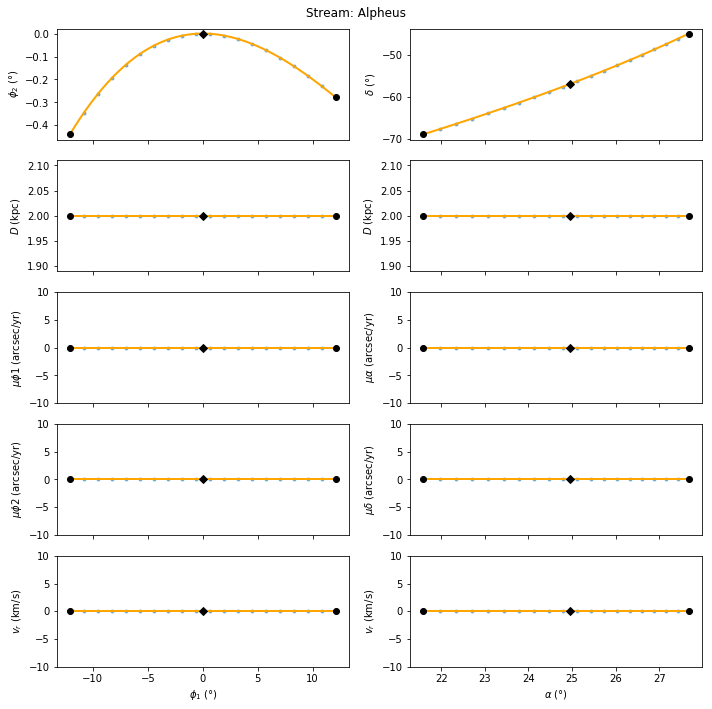

In [255]:
#Alpheus
dec=np.linspace(-69.,-45.,20)
ra = 32.116-0.00256*dec-0.00225*(dec**2)  #from Grillmair 2013
D = 2.*np.ones(ra.size)
zeros=np.zeros(ra.size)
Ref = "grillmair2013"
Name,ShortName= "Alpheus","Alp"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='icrs',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Hermus
=======

- Distance gradient implemented 18.01.2021

Hermus -> track.st.Hermus.grillmair2014.ecsv


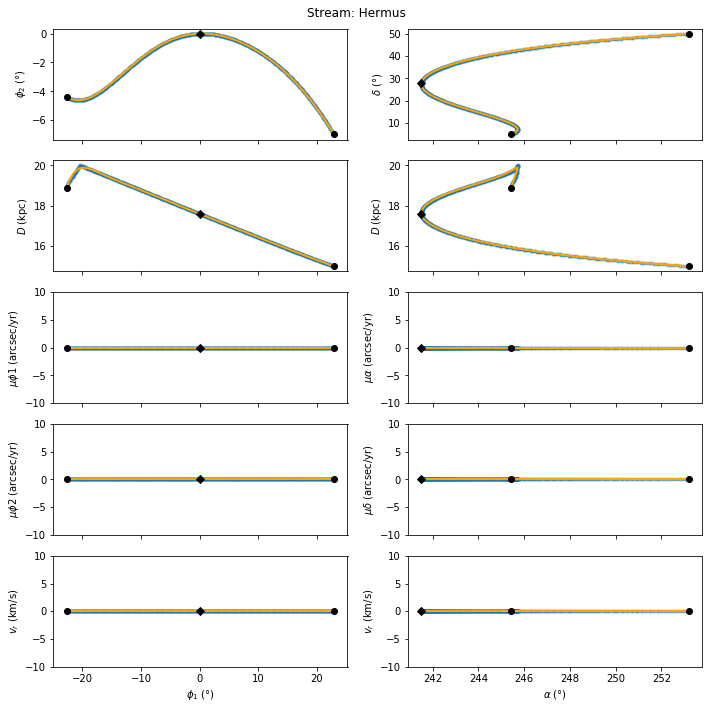

In [254]:

#Hermus
#from Grillmair 2014
N=500
dec=np.linspace(5.,+50.,500)
ra=241.571 + 1.37841*dec -0.148870*(dec**2) + 0.00589502*(dec**3) -1.03927E-4*(dec**4) + 7.28133E-7*(dec**5)
zeros=np.zeros(dec.size)
width=0.5*u.deg
#Grillmair says distance is: (15 north end, central 20, south 19) kpc
Fd = scipy.interpolate.interp1d([dec[0],dec[25],dec[-1]],[19.,20.,15.],kind='linear',bounds_error=False)
D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

#D = 18.+zeros

Ref = "grillmair2014"
Name,ShortName= "Hermus","Her"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=10, ShortName=ShortName, clf=False, plot_obs=True)

Hyllus
=======

- Distance gradient implemented 18.01.2021

Hyllus -> track.st.Hyllus.grillmair2014.ecsv


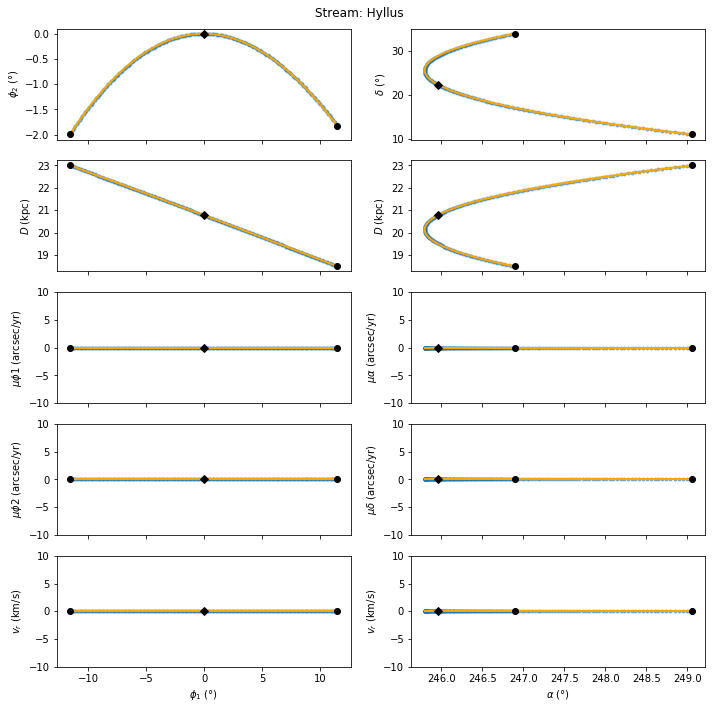

In [256]:
dec=np.linspace(11.,+34.,200)
ra=255.8150-0.78364*dec + 0.01532*dec**2
#D= north 18.5, south 23

zeros=np.zeros(ra.size)
width=0.5*u.deg
#Grillmair says distance is: (15 north end, central 20, south 19) kpc
Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2014"
Name,ShortName= "Hyllus","Hyl"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Murrumbidgee
===========

Murrumbidgee -> track.st.Murrumbidgee.grillmair2017b.ecsv


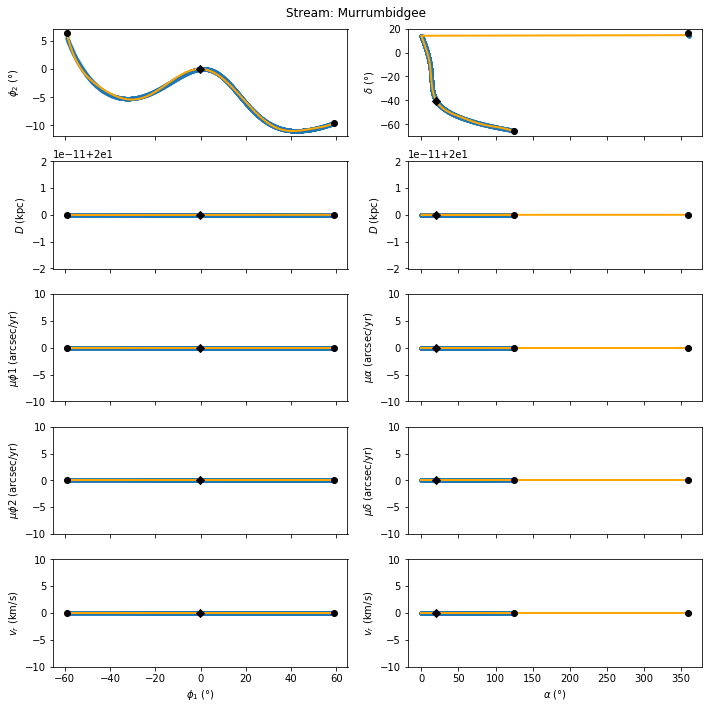

In [257]:
#Murrumbidgee, From Grillmair 2017b
dec=np.linspace(-65,+16.,3000)  
#dec range is not clear in G17's paper, the fiducial point is not included in the mentioned
#range -65<dec<-30.
#print bovyc.lb_to_radec(180.,-5.)
ra=367.893 -0.4647*dec -0.00862*dec**2 + 0.000118*dec**3 +1.2347e-6*dec**4 -1.13758e-7*dec**5
ra=ra % 360.

zeros=np.zeros(ra.size)
width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017b"
Name,ShortName= "Murrumbidgee","Mur"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=8, ShortName=ShortName, clf=False, plot_obs=True)

Molonglo
====

Molonglo -> track.st.Molonglo.grillmair2017b.ecsv


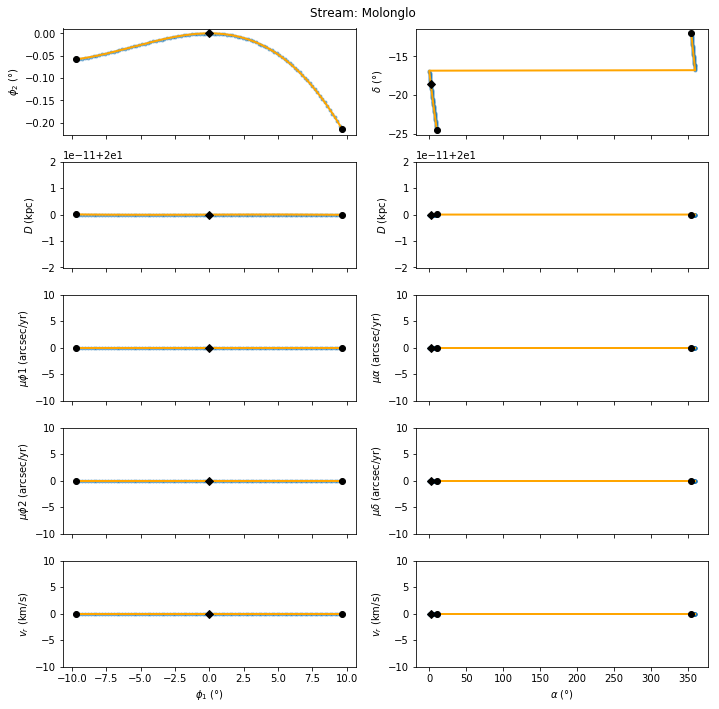

In [258]:
#Molonglo, From Grillmair 2017b
dec=np.linspace(-24.5,-12.,100)
ra=345.017 - 0.5843*dec + 0.0182*dec**2
ra=ra % 360.

zeros=np.zeros(ra.size)
#width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017b"
Name,ShortName= "Molonglo","Mol"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits = get_track_from_points(obs.icrs, deg=3.)

#Print track out
ofileroot = f"track.st.{Name}.{Ref}"
print(f"{Name} -> {ofileroot}.ecsv")
save_track_ecsv(f"{ofileroot}.ecsv",track)

#Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
ofilesn = f"{ofileroot}.summary.ecsv"    
save_summary_ecsv(ofilesn, track_end_points, track_mid_point, mid_pole, StreamName=Name, StreamShortName=ShortName )

#While we're at it. Make plot and save
stream_plot(obs, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png",  clf=False, StreamName=Name, plot_obs=True)

Orinoco
=====

Orinoco -> track.st.Orinoco.grillmair2017.ecsv


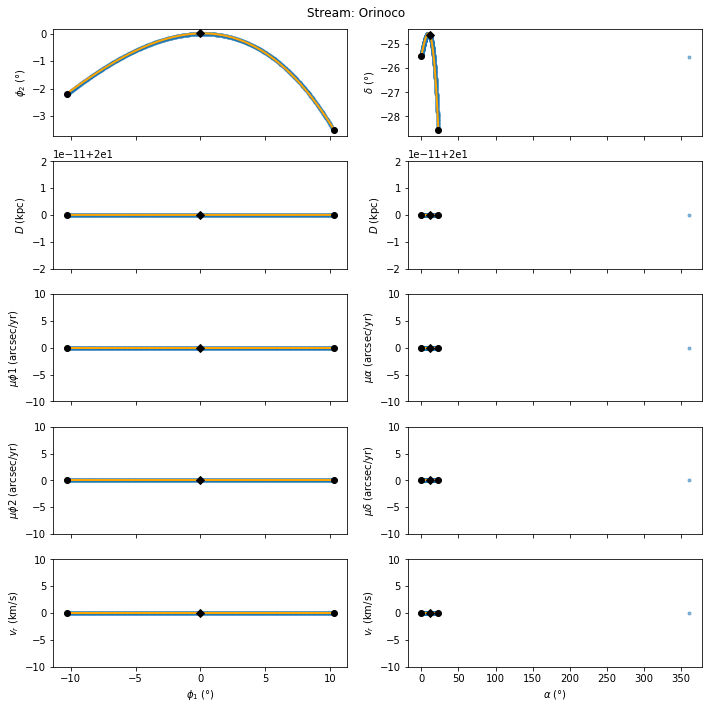

In [259]:
ra = np.linspace(0.,360.,10000)
dec = -25.5146 + 0.1672*ra -0.003827*ra**2 -0.0002835*ra**3 -5.3133e-6*ra**4
ra,dec=ra[np.abs(dec)<=90],dec[np.abs(dec)<=90]
maskb=(ra>(360-36)) | (ra<23) 
ra,dec=ra[maskb],dec[maskb]
zeros=np.zeros(ra.size)
#width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017"
Name,ShortName= "Orinoco","Ori"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

Kwando
=====

Kwando -> track.st.Kwando.grillmair2017.ecsv


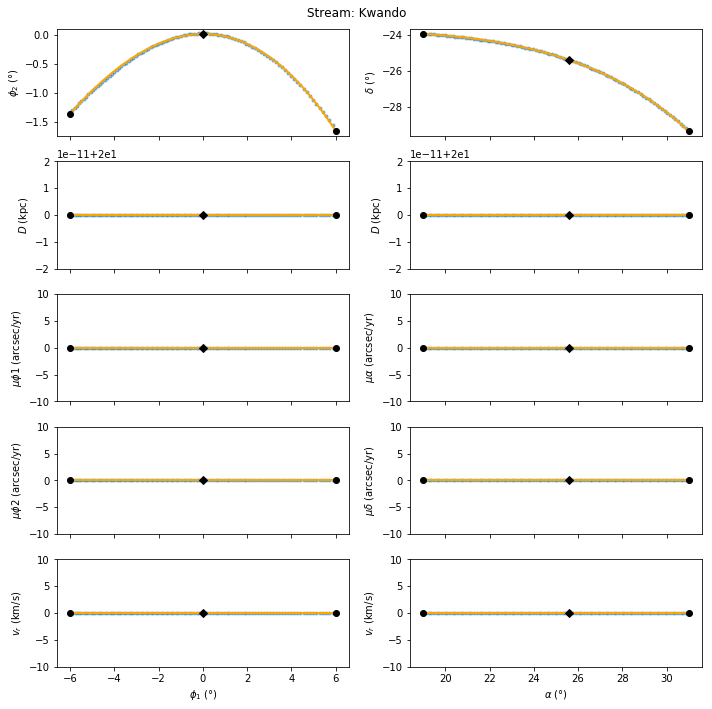

In [260]:
ra = np.linspace(19.,31.,100)
dec = -7.817 -2.354*ra +0.1202*ra**2 -0.00215*ra**3 
D=20*np.ones_like(ra)
zeros=np.zeros(ra.size)

Ref = "grillmair2017"
Name,ShortName= "Kwando","Kaw"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

In [206]:
def prueba(x,y=None):
    if y is None:  y=x[:3]
    print(x,y)
    
prueba("proebando")    

proebando pro


Orphan
=======

Orphan -> track.st.Orphan.koposov2019.ecsv


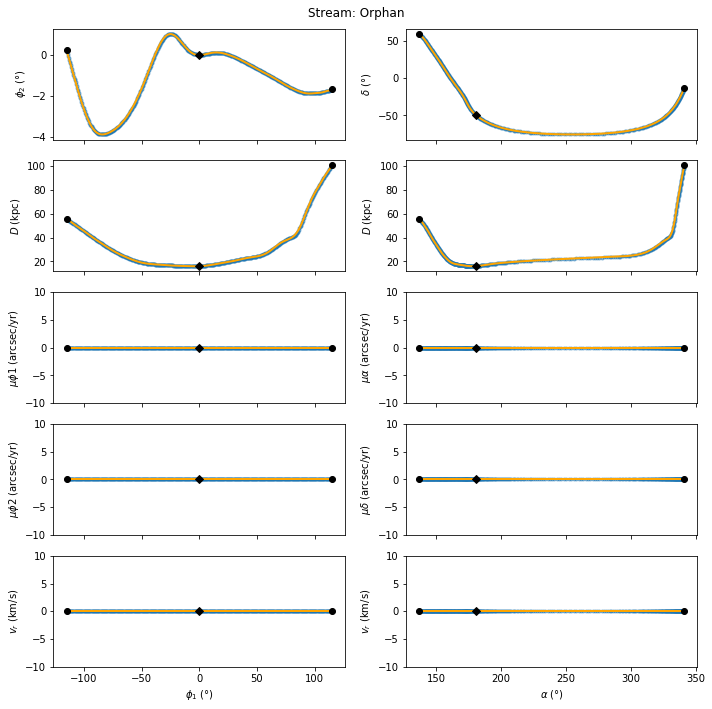

In [284]:
#Orphan footprint from Koposov et al. 2019 - Gaia DR2 RRLs.

#Knots for D(phi1) interpolation
phi1_Dknot=np.array([-100.0,-76.2169,-69.9684,-63.1307,-44.2712,-25.0268,-5.3975,20.0052,42.3287,61.958,90.0548,114.3027])   
Dknot=np.array([100.0,58.0,44.0,39.441,27.6252,22.5353,18.7178,15.9911,16.9,18.5361,29.2612,44.8945])
#phi1-phi2
#Knots for phi2(phi1) stream track interpolation
phi1k=np.array([-105.186,-74.7184,-54.4067,-25.4375,0.2019,25.8413,39.1605,66.9643,93.1032,108.0872,129.8974,162.5293])
phi2k=np.array([2.315,2.148,1.2797,-0.0562,-0.8577,-1.1917,-1.9598,1.1127,3.2835,3.2167,-0.1564,-4.8653])
#Interpolators
orphan_Dspline=scipy.interpolate.CubicSpline(phi1_Dknot,Dknot,bc_type='natural',extrapolate=True)
orphan_phi2spline=scipy.interpolate.CubicSpline(phi1k,phi2k,bc_type='natural')

#Plot to check
phi1s=np.linspace(-100,130,500)
Ds=orphan_Dspline(phi1s)
phi2s=orphan_phi2spline(phi1s)


#Rotation matrix from Koposov+ 2019 appendix
Mrot_radec_to_phi12=[[-0.44761231,-0.08785756,-0.88990128],
                     [-0.84246097,0.37511331,0.38671632],
                     [0.29983786,0.92280606,-0.2419219]]

stream_frame = gc.GreatCircleICRSFrame.from_R(Mrot_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=Ds*u.kpc, frame=stream_frame)

Ref = "koposov2019"
Name,ShortName= "Orphan","Orp"

zeros = np.zeros(stream_track.phi1.size)
obs = ac.SkyCoord(ra=stream_track.icrs.ra, dec=stream_track.icrs.dec, distance=stream_track.distance, frame='icrs',
                 pm_ra_cosdec=zeros*u.arcsec/u.yr, pm_dec=zeros*u.arcsec/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, deg=25, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True)

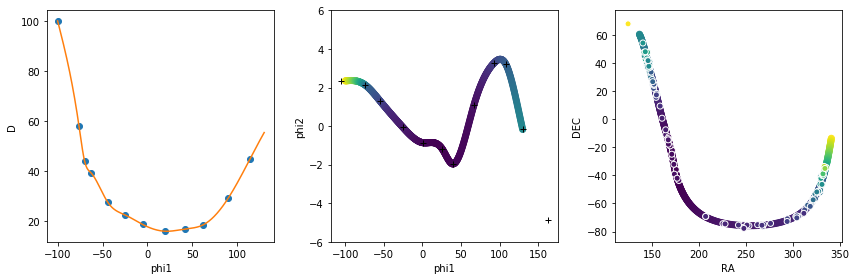

In [274]:
plt.figure(1,figsize=(12,4))
plt.subplot(131)
plt.plot(phi1_Dknot,Dknot,'o')
plt.plot(phi1s,Ds,'-')
plt.xlabel("phi1")
plt.ylabel("D")
plt.subplot(132)
plt.plot(phi1k,phi2k,'k+')
plt.scatter(phi1s,phi2s,c=Ds,marker='o')
plt.ylim(-6,6)
plt.xlabel("phi1")
plt.ylabel("phi2")

#Double check coordinate rotation with OATs RRLs 
rrs=pd.read_csv("/Users/cmateu/trabajo/research/aspen_orphan/orphan_rrl_members.alldata.csv")
plt.subplot(133)
#plt.scatter(ras,decs,c=Ds,marker='o')
plt.scatter(stream_track.icrs.ra.value,stream_track.icrs.dec.value,c=stream_track.distance.value,marker='o')
plt.scatter(rrs.RA,rrs.DEC,c=rrs.DIST,marker='o',edgecolors='w')
plt.xlabel("RA")
plt.ylabel("DEC")

plt.tight_layout()

Computations for lib_by_pair or lib_by_pole
================================================================================================

Pal 15 and Eridanus
-------------------

Computed from position angle (PA) and length of the tails from Myeong+ 2017. For each cluster they report the PA and length *l* for the 'tail 1' and 'tail 2', the two tails coming out of the cluster.

In [174]:
#Pal 15
rac,decc=255.01,-0.5419
l1,PA1=59./60.,np.radians(340.)
l2,PA2=29./60.,np.radians(150.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l2*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l2*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

255.34633485050725 -1.4659310771061431
254.7683225240729 -0.12332105483752132


In [177]:
#Eridanus
rac,decc=66.1854,-21.1869
l1,PA1=18./60.,np.radians(40.)
l2,PA2=11./60.,np.radians(220.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l1*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l1*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

65.97858431221822 -21.416713332935696
66.39221568778179 -20.957086667064306


Jet Stream
----

133.7568582473552 -27.702345529649296
141.99825582365125 -17.81505042193316


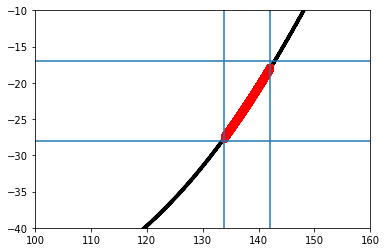

In [268]:
#props
dist=28.6 #kpc
width=0.18
#RA-DEC pole
gcra_all,gcdec_all=galstreams.gcutils.get_gc_for_pole(64.983, 34.747,degree=True,dlat=width)

plt.plot(gcra_all,gcdec_all,'k.',ms=1)

#Limit to reported RA and DEC ranges
ramin,ramax=15.*(8.+55./60.),15*(9.+28./60.)
decmin,decmax=-28.,-17.
#print ramin, ramax, decmin, decmax

jetmask=(gcra_all>=ramin) & (gcra_all<=ramax) & (gcdec_all>=decmin) & (gcdec_all<=decmax)
gcra_jet,gcdec_jet=gcra_all[jetmask],gcdec_all[jetmask]

plt.plot(gcra_jet,gcdec_jet,'ro')

plt.axvline(ramin)
plt.axvline(ramax)
plt.axhline(decmin)
plt.axhline(decmax)

plt.ylim(-40,-10)
plt.xlim(100,160)

#Print only end-points so this can be defined by lib_by_pair
print(gcra_jet[0],gcdec_jet[0])
print(gcra_jet[-1],gcdec_jet[-1])


Notes on Excluded Streams
===========

 S1-4 streams (Myeong et al. 2018)
 ---
*These streams/moving groups are too close or even surround the Sun, hence they are excluded from the library*

In [ ]:
#From Table 1, Myeong, et al. Monthly Notices RAS 475, 1537–1548 (2018). 
#Coordinates are galactocentric with Sun at +8.5 (approx., the paper is not explicit)
xyz_medians=[ (8.1,-0.2,2.8), (8.7,0.3,0.8), (8.6,0.5,3.5), (8.5,0.6,4.1)]
xyz_dispersions=[(0.8,1.2,1.9),(0.6,1.0,2.0), (1.1,1.5,1.9), (1.0,1.7,3.6)]
sns.set_style("whitegrid")
plt.figure(1,figsize=(12,8))
for ii in range(len(xyz_medians)):
    xs=np.random.normal(loc=xyz_medians[ii][0],scale=xyz_dispersions[ii][0],size=200)
    ys=np.random.normal(loc=xyz_medians[ii][1],scale=xyz_dispersions[ii][1],size=200)
    zs=np.random.normal(loc=xyz_medians[ii][2],scale=xyz_dispersions[ii][2],size=200)
    plt.subplot(2,4,ii+1)
    plt.title("S{0}".format(ii+1))
    plt.plot(xs,ys,'o',alpha=0.5)
    plt.grid(axis='both',which='both',lw=1)
    
    #Convert to heliocentric coords
#     ss=astropy.coordinates.SkyCoord(xs-8.5,ys,zs, unit='kpc',
#                                 representation='cartesian', frame='galactic')
    plt.subplot(2,4,5+ii)
#     plt.plot(ss.icrs.galactic.l,ss.icrs.galactic.b,'o',alpha=0.5)
    #Double check
    ll,bb,dd=bovyc.XYZ_to_lbd(xs-8.5,ys,zs,degree=True).T
    #plt.plot(ll,bb,'o',alpha=0.5)
    ssg=astropy.coordinates.SkyCoord(l=ll*astropy.units.deg,b=bb*astropy.units.deg,frame='galactic')
    plt.plot(ssg.l.wrap_at(180.*astropy.units.deg),ssg.b,'x')
plt.tight_layout()

#plt.plot(ssh.ra,ssh.dec,'o')

Extras - Playpen
====

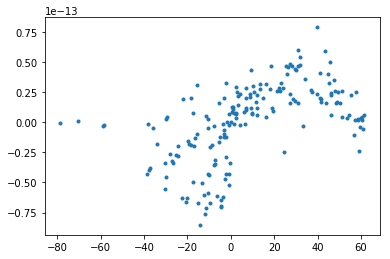

In [725]:
ibs.radial_velocity.min(),ibs.radial_velocity.max()
plt.plot(ibs.transform_to(stream_fr).phi1,ibs.transform_to(stream_fr).radial_velocity,'.')

In [726]:
ibs.transform_to(stream_fr).radial_velocity.min(),ibs.transform_to(stream_fr).radial_velocity.max()

(<Quantity -8.52602672e-14 km / s>, <Quantity 7.88789046e-14 km / s>)

Tests
======

In [266]:
#c_gc=c.transform_to(ac.Galactocentric)
#c_gc.spherical.lon